https://github.com/kexinhuang12345/DeepPurpose


In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()


✨🍰✨ Everything looks OK!


In [2]:
!mamba install -c conda-forge -c rdkit rdkit notebook -y


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        Supported by @QuantStack

        GitHub:  https://github.com/QuantStack/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████

Getting  conda-forge linux-64
Getting  conda-forge noarch
Getting  rdkit linux-64
Getting  rdkit noarch
Getting  pkgs/main linu

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
# !source activate DeepPurpose
!pip install scikit-learn numpy pandas
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install git+https://github.com/bp-kelley/descriptastorus 
!pip install DeepPurpose prody

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Cloning https://github.com/bp-kelley/descriptastorus to /tmp/pip-req-build-us7_yept
  Running command git clone -q https://github.com/bp-kelley/descriptastorus /tmp/pip-req-build-us7_yept


In [5]:
!python -V


Python 3.7.10


In [6]:
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
import pandas as pd
from DeepPurpose import DTI as models
from DeepPurpose.utils import *
from DeepPurpose.dataset import *


In [7]:
#!wget https://drive.google.com/file/d/1qnvNxd6SvhwHPxD0huTpmODB270ENs7j/view?usp=sharing -O data.tar.gz


In [8]:
import numpy as np
import random
import torch
from prody import parsePDB

def seed_everything(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    pass

In [9]:
# Cell with constants
DATADIR = Path("data")
if not DATADIR.exists():
  # DATADIR.mkdir(DATADIR)
  !gdown --id 1qnvNxd6SvhwHPxD0huTpmODB270ENs7j
  !tar -xzvf inhibitors_data.tar.gz

RANDOM_SEED = 2407
seed_everything(RANDOM_SEED)
TMP_DIR = Path("tmp")
TMP_DIR.mkdir(exist_ok=True)

train_df = pd.read_csv(DATADIR / "train.csv", index_col=0)
test_df = pd.read_csv(DATADIR / "test.csv", index_col=0)

MODEL_NAME = 'Daylight_AAC_BindingDB'  # 'Morgan_AAC_BindingDB'
SMILES_COL = "Smiles"
NFOLDS = 5

In [10]:
!ls

condacolab_install.log	inhibitors_data.tar.gz	runs	     save_folder
data			result			sample_data  tmp


In [11]:

structure = parsePDB((DATADIR / 'target.pdb').as_posix(), debug=False)
#[x.name for x in structure.get_atoms() if not x.is_disordered()]
# [x.get_resname() for x in structure.get_residues()]
#structure.getSequence(), structure.getResnums(), [a for a in structure.iterAtoms()]
list(structure.iterChains())
calphas = structure.chain_A_and_calpha
sequence = calphas.getSequence()
sequence

@> 2874 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2874 atoms and 1 coordinate set(s) were parsed in 0.05s.


'EVNSFSGYLKLTDNVYIKNADIVEEAKKVKPTVVVNAANVYLKHGGGVAGALNKATNNAMQVESDDYIATNGPLKVGGSCVLSGHNLAKHCLHVVGPNVNKGEDIQLLKSAYENFNQHEVLLAPLLSAGIFGADPIHSLRVCVDTVRTNVYLAVFDKNLYDKLVSSFLE'

In [12]:
def balance_data(train_df, target_col="Label"):
    df = train_df[target_col].value_counts()
    m = df.max()
    new_index = []
    for i, c in df.reset_index().values:
        ids = train_df[target_col]==i
        values = train_df[ids].index
        if c == m:
            new_index.extend(values)
        else:
            new_index.extend(np.random.choice(values, m))
    np.random.shuffle(new_index)
    return train_df.loc[new_index]

Drug Target Interaction Prediction Mode...
in total: 5557 drug-target pairs
encoding drug...
unique drugs: 5557
rdkit not found this smiles: [I-].[K+] convert to all 0 features
encoding protein...
unique target sequence: 1
-- Encoding AAC takes time. Time Reference: 24s for ~100 sequences in a CPU.				 Calculate your time by the unique target sequence #, instead of the entire dataset.
splitting dataset...
do not do train/test split on the data for already splitted data
Dataset already downloaded in the local system...
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 2.87363. Total time 0.00027 hours
Training at Epoch 1 iteration 100 with loss 0.70097. Total time 0.00138 hours
Validation at Epoch 1, AUROC: 0.57575 , AUPRC: 0.07898 , F1: 0.08333 , Cross-entropy Loss: 9.56669
Training at Epoch 2 iteration 0 with loss 0.46147. Total time 0.00194 hours
Training at Epoch 2 iteration 100 with loss 0.23770. Total time 0.0025 hours
Vali

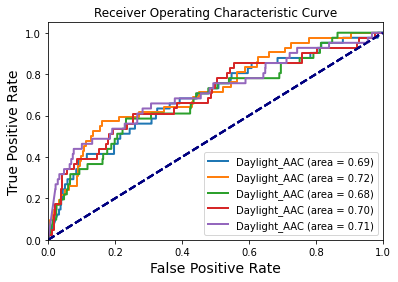

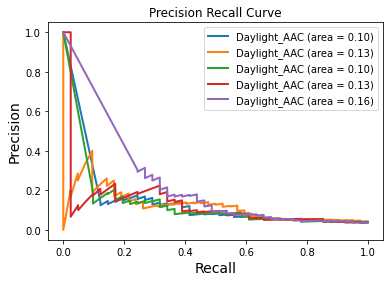

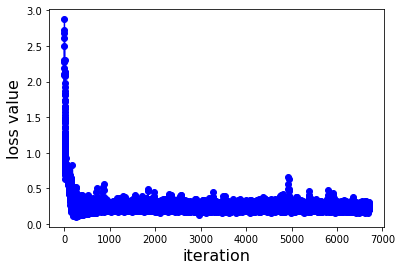

In [13]:
from sklearn.model_selection import StratifiedKFold
# Load Data, an array of SMILES for drug, an array of Amino Acid Sequence for Target and an array of binding values/0-1 label.
# e.g. ['Cc1ccc(CNS(=O)(=O)c2ccc(s2)S(N)(=O)=O)cc1', ...], ['MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTH...', ...], [0.46, 0.49, ...]
# In this example, BindingDB with Kd binding score is used.
# X_drug, X_target, y  = process_BindingDB(download_BindingDB(SAVE_PATH),
# 					 y = 'Kd', 
# 					 binary = False, 
# 					 convert_to_log = True)


X_drug = list(train_df[SMILES_COL].values)
X_target = [sequence] *train_df.shape[0]
y = train_df.Active.values*1
# Type in the encoding names for drug/protein.
drug_encoding, target_encoding = 'Daylight', 'AAC'

# Data processing, here we select cold protein split setup.
train = data_process(
    X_drug, X_target, y, 
    drug_encoding, target_encoding, 
    split_method="no_split",
    #split_method='random', 
    #frac=[0.9, 0.1, 0.0],
    random_seed=RANDOM_SEED
)
#train_balanced = balance_data(train)

# net = models.model_pretrained(model=MODEL_NAME, path_dir=TMP_DIR, )
# net.config['train_epoch'] = 15*2
# net.config['batch_size'] = 64
# net.train(train_balanced, val)


skf = StratifiedKFold(n_splits=NFOLDS, random_state=RANDOM_SEED, shuffle=True)
for fold, (train_index, test_index) in enumerate(skf.split(train.index, train.Label)):
  train_ds = train.loc[train_index].reset_index(drop=True)
  val_ds = train.loc[test_index].reset_index(drop=True)
  train_balanced = balance_data(train_ds)
  net = models.model_pretrained(model=MODEL_NAME, path_dir=TMP_DIR/ f"model{fold}")
  net.config['train_epoch'] = 5*10
  net.config['batch_size'] = 64
  net.config['decay'] = 0.1
  net.config['result_folder'] = (TMP_DIR/"results/").as_posix()
  net.train(train_balanced, val_ds, val_ds)
  net.save_model((TMP_DIR/f"model_save{fold}").as_posix())

  # break

In [14]:
# net.config

In [15]:
X_drug = test_df.Smiles.values  # ['CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC=C4)N']
X_target = [sequence]*len(X_drug) # ['MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQVTVDEVLAEGGFAIVFLVRTSNGMKCALKRMFVNNEHDLQVCKREIQIMRDLSGHKNIVGYIDSSINNVSSGDVWEVLILMDFCRGGQVVNLMNQRLQTGFTENEVLQIFCDTCEAVARLHQCKTPIIHRDLKVENILLHDRGHYVLCDFGSATNKFQNPQTEGVNAVEDEIKKYTTLSYRAPEMVNLYSGKIITTKADIWALGCLLYKLCYFTLPFGESQVAICDGNFTIPDNSRYSQDMHCLIRYMLEPDPDKRPDIYQVSYFSFKLLKKECPIPNVQNSPIPAKLPEPVKASEAAAKKTQPKARLTDPIPTTETSIAPRQRPKAGQTQPNPGILPIQPALTPRKRATVQPPPQAAGSSNQPGLLASVPQPKPQAPPSQPLPQTQAKQPQAPPTPQQTPSTQAQGLPAQAQATPQHQQQLFLKQQQQQQQPPPAQQQPAGTFYQQQQAQTQQFQAVHPATQKPAIAQFPVVSQGGSQQQLMQNFYQQQQQQQQQQQQQQLATALHQQQLMTQQAALQQKPTMAAGQQPQPQPAAAPQPAPAQEPAIQAPVRQQPKVQTTPPPAVQGQKVGSLTPPSSPKTQRAGHRRILSDVTHSAVFGVPASKSTQLLQAAAAEASLNKSKSATTTPSGSPRTSQQNVYNPSEGSTWNPFDDDNFSKLTAEELLNKDFAKLGEGKHPEKLGGSAESLIPGFQSTQGDAFATTSFSAGTAEKRKGGQTVDSGLPLLSVSDPFIPLQVPDAPEKLIEGLKSPDTSLLLPDLLPMTDPFGSTSDAVIEKADVAVESLIPGLEPPVPQRLPSQTESVTSNRTDSLTGEDSLLDCSLLSNPTTDLLEEFAPTAISAPVHKAAEDSNLISGFDVPEGSDKVAEDEFDPIPVLITKNPQGGHSRNSSGSSESSLPNLARSLLLVDQLIDL']
y = [0.5]*len(X_drug)
# from DeepPurpose import utils
X_pred = data_process(
    X_drug, X_target, y, 
    drug_encoding, target_encoding, 
    split_method='no_split',
    random_seed=1
)
train_predictions = []
test_predictions = []
for fold in range(NFOLDS):
  print(f"Predicting with fold {fold}")
  net = models.model_pretrained((TMP_DIR/f"model_save{fold}").as_posix())
  y_pred = net.predict(X_pred)
  y_pred = np.asarray(y_pred)
  test_predictions.append(y_pred)

  train_pred = net.predict(train)
  train_predictions.append(np.asarray(train_pred))

Drug Target Interaction Prediction Mode...
in total: 1614 drug-target pairs
encoding drug...
unique drugs: 1614
encoding protein...
unique target sequence: 1
-- Encoding AAC takes time. Time Reference: 24s for ~100 sequences in a CPU.				 Calculate your time by the unique target sequence #, instead of the entire dataset.
splitting dataset...
do not do train/test split on the data for already splitted data
Predicting with fold 0
predicting...
predicting...
Predicting with fold 1
predicting...
predicting...
Predicting with fold 2
predicting...
predicting...
Predicting with fold 3
predicting...
predicting...
Predicting with fold 4
predicting...
predicting...


In [16]:
from sklearn.metrics import roc_curve, f1_score

# todo: add cv
def agg_strategy(predictions, method="mean"):
  predictions = np.stack(predictions)
  if method == "mean":
    return predictions.mean(0)
  if method == "median":
    return np.median(predictions, axis=0)
  return predictions.min(0)

train_scores = agg_strategy(train_predictions)

fpr, tpr, thresholds = roc_curve(train.Label.values, train_scores)
optimal_threshold = thresholds[np.argmax(tpr-fpr)]
print("Optimal threshold:", optimal_threshold)
print("F1 score:", f1_score(train.Label.values, train_scores >= optimal_threshold))

Optimal threshold: 0.49690759032964704
F1 score: 0.4927536231884058


In [17]:

test_df['Active'] = agg_strategy(test_predictions) >= optimal_threshold

In [18]:
SUBMISSION_NAME = "submission_deeppurpose_v0.csv"
test_df.to_csv(SUBMISSION_NAME)

In [19]:
from google.colab import files
files.download(SUBMISSION_NAME) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>